## 1. Import Library

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import random
from collections import Counter
from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,  ReduceLROnPlateau

# Reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Load data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
file_path = "/content/drive/MyDrive/ulasan_aplikasi_tokped.csv"
df = pd.read_csv(file_path)
df.dropna(subset=['content'], inplace=True)
df = df[df['content'].str.strip() != '']
df = df.reset_index(drop=True)
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,5df23897-066b-4b12-a4b6-8d65edfbb630,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"sulit buat retur barang, udah mengajukan penge...",1,20,3.330.0,2025-09-22 04:18:20,NaN,NaN,3.330.0
1,40e370ad-2183-4786-a3f0-49772cea7bdb,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Maaf Respon TokopediaCare Buruk!!! Lebih serin...,4,733,3.328.0,2025-09-05 03:12:13,"Halo Toppers, terima kasih atas rating yang ka...",2024-11-23 04:28:01,3.328.0
2,c2427d25-183e-4d0f-9810-0b0c96628b8e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Kecewa sih, return barang karena kesalahan pen...",1,72,3.328.0,2025-09-11 22:39:52,NaN,NaN,3.328.0
3,fd623205-2a98-44ad-9d6a-c2fbbd46bd5d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Tokopedia sekarang kayak t*i, event promo kupo...",1,45,3.329.0,2025-09-16 03:13:20,NaN,NaN,3.329.0
4,8eb178f0-c1e3-4448-85a1-a4db9780223f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Sistem agak down mungkin ya akhir akhir ini, m...",3,10,3.329.0,2025-09-17 03:53:24,NaN,NaN,3.329.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12000 non-null  object
 1   userName              12000 non-null  object
 2   userImage             12000 non-null  object
 3   content               12000 non-null  object
 4   score                 12000 non-null  int64 
 5   thumbsUpCount         12000 non-null  int64 
 6   reviewCreatedVersion  9263 non-null   object
 7   at                    12000 non-null  object
 8   replyContent          6571 non-null   object
 9   repliedAt             6571 non-null   object
 10  appVersion            9263 non-null   object
dtypes: int64(2), object(9)
memory usage: 1.0+ MB


## 3. Labeling Sentimen

In [10]:
def label_sentiment(score):
    if score <= 2:
        return 'negatif'
    elif score == 3:
        return 'netral'
    else:
        return 'positif'

df['label'] = df['score'].apply(label_sentiment)
df['label'].value_counts()

,count
label,
negatif,8036
positif,2896
netral,1068


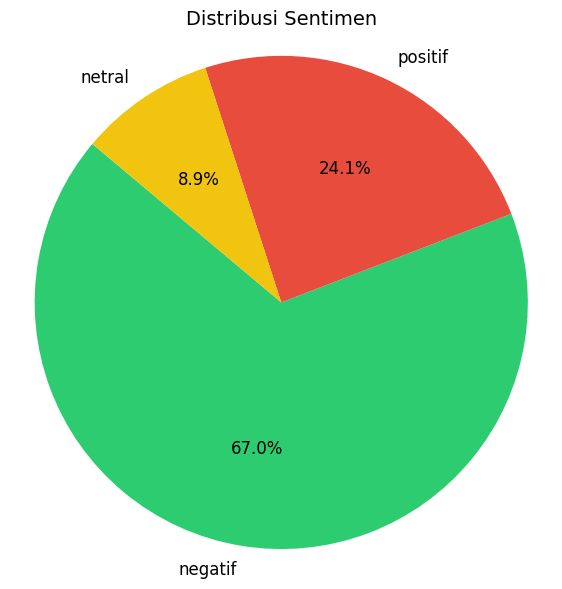

In [11]:
# Hitung jumlah masing-masing label
label_counts = df['label'].value_counts()

# Pie Chart
plt.figure(figsize=(7, 7))
colors = ['#2ecc71', '#e74c3c', '#f1c40f']
plt.pie(
    label_counts,
    labels=label_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 12}
)
plt.axis('equal')
plt.title('Distribusi Sentimen', fontsize=14)
plt.show()

## 4. Preprocessing

In [12]:
stop_words = set(stopwords.words("indonesian"))
stemmer = StemmerFactory().create_stemmer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess_text(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

df["processed_content"] = df["content"].astype(str).apply(preprocess_text)
print("\nContoh sebelum & sesudah preprocessing:")
print(df[["content", "processed_content"]].head(5))


Contoh sebelum & sesudah preprocessing:
                                             content  \
0  sulit buat retur barang, udah mengajukan penge...   
1  Maaf Respon TokopediaCare Buruk!!! Lebih serin...   
2  Kecewa sih, return barang karena kesalahan pen...   
3  Tokopedia sekarang kayak t*i, event promo kupo...   
4  Sistem agak down mungkin ya akhir akhir ini, m...   

                                   processed_content  
0  sulit retur barang udah aju kembali udah tuju ...  
1  maaf respon tokopediacare buruk robot tampil u...  
2  kecewa sih return barang salah jual jual tuju ...  
3  tokopedia kayak ti event promo kupon transpara...  
4  sistem down ya bayar tagih pulsa checkout prod...  


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12000 non-null  object
 1   userName              12000 non-null  object
 2   userImage             12000 non-null  object
 3   content               12000 non-null  object
 4   score                 12000 non-null  int64 
 5   thumbsUpCount         12000 non-null  int64 
 6   reviewCreatedVersion  9263 non-null   object
 7   at                    12000 non-null  object
 8   replyContent          6571 non-null   object
 9   repliedAt             6571 non-null   object
 10  appVersion            9263 non-null   object
 11  label                 12000 non-null  object
 12  processed_content     12000 non-null  object
dtypes: int64(2), object(11)
memory usage: 1.2+ MB


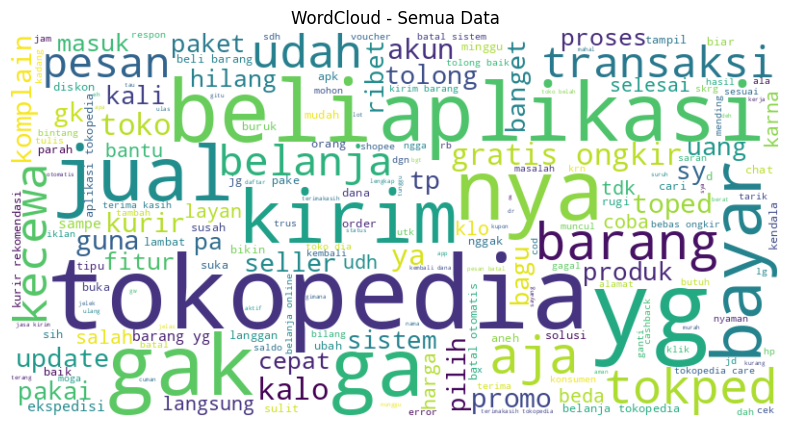

In [14]:
# WordCloud Semua Data
text_all = ' '.join(df['processed_content'].astype(str))
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(text_all)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Semua Data')
plt.show()

## 5. Balancing Data

In [15]:
# A. Distribusi awal & normalisasi label
print("Distribusi awal:", Counter(df['label'].astype(str)))

df['label'] = df['label'].astype(str).str.strip().str.capitalize()
print("Distribusi (normalized):", Counter(df['label']))


# B. Upsample kelas minoritas
def upsample_minority(df, label_col='label', target_per_class=None, random_state=42):
    rng = np.random.RandomState(random_state)
    counts = df[label_col].value_counts()
    if target_per_class is None:
        target = counts.max()
    else:
        target = target_per_class
    frames = []
    for lab, cnt in counts.items():
        sub = df[df[label_col] == lab]
        if cnt >= target:
            frames.append(sub.sample(n=target, replace=False, random_state=rng))
        else:
            extra = sub.sample(n=target-cnt, replace=True, random_state=rng)
            frames.append(pd.concat([sub, extra], ignore_index=True))
    df_up = pd.concat(frames, ignore_index=True).sample(frac=1.0, random_state=rng).reset_index(drop=True)
    return df_up

df_up = upsample_minority(df, label_col='label', target_per_class=None)
print("Distribusi setelah upsample:", df_up['label'].value_counts())


# C. Augmentasi ringan untuk kelas Netral
def random_deletion(words, p=0.1):
    if len(words) == 1:
        return words
    remaining = [w for w in words if random.random() > p]
    if len(remaining) == 0:
        return [random.choice(words)]
    return remaining

def augment_text(text, p=0.1):
    tokens = text.split()
    new = random_deletion(tokens, p=p)
    return " ".join(new)

netral_df = df_up[df_up['label']=='Netral']
aug_list = []
for idx, row in netral_df.iterrows():
    for _ in range(2):
        aug_text = augment_text(row['processed_content'], p=0.12)
        new_row = row.copy()
        new_row['processed_content'] = aug_text
        aug_list.append(new_row)

if len(aug_list) > 0:
    df_aug = pd.concat([df_up, pd.DataFrame(aug_list)], ignore_index=True).sample(frac=1, random_state=42)
else:
    df_aug = df_up

print("Distribusi setelah augmentasi:", df_aug['label'].value_counts())


# D. Tokenisasi & Label Encoding
X_texts = df_aug['processed_content'].astype(str).tolist()
y_labels = df_aug['label'].astype(str).tolist()

le = LabelEncoder()
y_enc = le.fit_transform(y_labels)
y_cat = to_categorical(y_enc)

MAX_WORDS = 10000
MAX_SEQ_LEN = 200
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_texts)
X_seq = tokenizer.texts_to_sequences(X_texts)
X_pad = pad_sequences(X_seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

print("Shape X_pad:", X_pad.shape, "Classes:", le.classes_)


# E. Class Weights
cw = compute_class_weight(class_weight='balanced', classes=np.unique(y_enc), y=y_enc)
class_weights = dict(enumerate(cw))
print("Class Weights:", class_weights)

Distribusi awal: Counter({'negatif': 8036, 'positif': 2896, 'netral': 1068})
Distribusi (normalized): Counter({'Negatif': 8036, 'Positif': 2896, 'Netral': 1068})
Distribusi setelah upsample: label
Positif    8036
Negatif    8036
Netral     8036
Name: count, dtype: int64
Distribusi setelah augmentasi: label
Netral     24108
Negatif     8036
Positif     8036
Name: count, dtype: int64
Shape X_pad: (40180, 200) Classes: ['Negatif' 'Netral' 'Positif']
Class Weights: {0: np.float64(1.6666666666666667), 1: np.float64(0.5555555555555556), 2: np.float64(1.6666666666666667)}


## 6. Pembangunan dan Pelatihan Model Deep Learning

### Model 1 - Bidirectional LSTM

In [16]:
def build_light_bilstm(max_words=MAX_WORDS, max_len=MAX_SEQ_LEN, embed_dim=100, n_classes=len(le.classes_)):
    model = Sequential()
    model.add(Embedding(max_words, embed_dim, input_length=max_len))
    model.add(Bidirectional(LSTM(48, return_sequences=False, dropout=0.2, recurrent_dropout=0.1)))
    model.add(Dropout(0.6))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(1e-3),
                  metrics=['accuracy'])
    return model

In [17]:
X_tr, X_te, y_tr, y_te = train_test_split(X_pad, y_cat, test_size=0.2, stratify=y_enc, random_state=42)

model = build_light_bilstm()
es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(X_tr, y_tr,
                    validation_data=(X_te, y_te),
                    epochs=20,
                    batch_size=128,
                    callbacks=[es, rl],
                    class_weight=class_weights,
                    verbose=2)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


252/252 - 183s - 727ms/step - accuracy: 0.6486 - loss: 0.7495 - val_accuracy: 0.8538 - val_loss: 0.4489 - learning_rate: 1.0000e-03
Epoch 2/20
252/252 - 200s - 795ms/step - accuracy: 0.8831 - loss: 0.3910 - val_accuracy: 0.9087 - val_loss: 0.2767 - learning_rate: 1.0000e-03
Epoch 3/20
252/252 - 173s - 687ms/step - accuracy: 0.9252 - loss: 0.2655 - val_accuracy: 0.9265 - val_loss: 0.2288 - learning_rate: 1.0000e-03
Epoch 4/20
252/252 - 203s - 805ms/step - accuracy: 0.9426 - loss: 0.2119 - val_accuracy: 0.9334 - val_loss: 0.2313 - learning_rate: 1.0000e-03
Epoch 5/20

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
252/252 - 202s - 803ms/step - accuracy: 0.9521 - loss: 0.1752 - val_accuracy: 0.9215 - val_loss: 0.2531 - learning_rate: 1.0000e-03
Epoch 6/20
252/252 - 174s - 690ms/step - accuracy: 0.9633 - loss: 0.1375 - val_accuracy: 0.9413 - val_loss: 0.2097 - learning_rate: 5.0000e-04
Epoch 7/20
252/252 - 202s - 803ms/step - accuracy: 0.9703 - loss: 0.1124 - v

In [18]:
y_pred = np.argmax(model.predict(X_te), axis=1)
y_true = np.argmax(y_te, axis=1)

# Akurasi Training
train_acc = model.evaluate(X_tr, y_tr, verbose=0)[1] * 100
# Akurasi Testing
test_acc = model.evaluate(X_te, y_te, verbose=0)[1] * 100

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))
print(f"Training set: {train_acc:.2f}%")
print(f"Testing set: {test_acc:.2f}%")

252/252 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step

Classification Report:
               precision    recall  f1-score   support

     Negatif       0.89      0.85      0.87      1607
      Netral       0.97      0.99      0.98      4822
     Positif       0.91      0.90      0.91      1607

    accuracy                           0.94      8036
   macro avg       0.92      0.91      0.92      8036
weighted avg       0.94      0.94      0.94      8036

Training set: 97.92%
Testing set: 94.13%


### Model 2 - CNN + LSTM

In [33]:
def build_cnn_lstm(max_words=MAX_WORDS, max_len=MAX_SEQ_LEN, embed_dim=128, n_classes=len(le.classes_)):
    model = Sequential()
    model.add(Embedding(max_words, embed_dim, input_length=max_len))
    model.add(Conv1D(64, 5, activation="relu", padding="same"))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(n_classes, activation="softmax"))

    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["accuracy"])
    return model

In [34]:
X_tr, X_te, y_tr, y_te = train_test_split(X_pad, y_cat, test_size=0.2, stratify=y_enc, random_state=42)

model = build_cnn_lstm()
es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(X_tr, y_tr,
                    validation_data=(X_te, y_te),
                    epochs=20,
                    batch_size=128,
                    callbacks=[es, rl],
                    class_weight=class_weights,
                    verbose=2)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


252/252 - 177s - 703ms/step - accuracy: 0.7312 - loss: 0.6274 - val_accuracy: 0.8864 - val_loss: 0.3348 - learning_rate: 1.0000e-03
Epoch 2/20
252/252 - 151s - 598ms/step - accuracy: 0.9166 - loss: 0.2846 - val_accuracy: 0.9328 - val_loss: 0.2143 - learning_rate: 1.0000e-03
Epoch 3/20
252/252 - 203s - 804ms/step - accuracy: 0.9515 - loss: 0.1747 - val_accuracy: 0.9421 - val_loss: 0.2006 - learning_rate: 1.0000e-03
Epoch 4/20
252/252 - 150s - 596ms/step - accuracy: 0.9663 - loss: 0.1229 - val_accuracy: 0.9462 - val_loss: 0.2026 - learning_rate: 1.0000e-03
Epoch 5/20

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
252/252 - 150s - 594ms/step - accuracy: 0.9757 - loss: 0.0912 - val_accuracy: 0.9491 - val_loss: 0.2054 - learning_rate: 1.0000e-03
Epoch 6/20
252/252 - 204s - 809ms/step - accuracy: 0.9863 - loss: 0.0539 - val_accuracy: 0.9522 - val_loss: 0.2201 - learning_rate: 5.0000e-04
Epoch 7/20

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.000250000

In [35]:
train_acc = model.evaluate(X_tr, y_tr, verbose=0)[1] * 100
test_acc = model.evaluate(X_te, y_te, verbose=0)[1] * 100

print(f"\nTraining set: {train_acc:.2f}%")
print(f"Testing set: {test_acc:.2f}%")


Training set: 97.53%
Testing set: 94.21%


### Model 3 - GRU

In [36]:
def build_gru(max_words=MAX_WORDS, max_len=MAX_SEQ_LEN, embed_dim=128, n_classes=len(le.classes_)):
    model = Sequential()
    model.add(Embedding(max_words, embed_dim, input_length=max_len))
    model.add(Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(n_classes, activation="softmax"))

    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["accuracy"])
    return model

In [37]:
X_tr, X_te, y_tr, y_te = train_test_split(X_pad, y_cat, test_size=0.2, stratify=y_enc, random_state=42)

model = build_gru()
es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(X_tr, y_tr,
                    validation_data=(X_te, y_te),
                    epochs=20,
                    batch_size=128,
                    callbacks=[es, rl],
                    class_weight=class_weights,
                    verbose=2)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


252/252 - 230s - 913ms/step - accuracy: 0.6986 - loss: 0.6788 - val_accuracy: 0.8754 - val_loss: 0.3821 - learning_rate: 1.0000e-03
Epoch 2/20
252/252 - 220s - 873ms/step - accuracy: 0.8894 - loss: 0.3570 - val_accuracy: 0.9179 - val_loss: 0.2492 - learning_rate: 1.0000e-03
Epoch 3/20
252/252 - 260s - 1s/step - accuracy: 0.9293 - loss: 0.2506 - val_accuracy: 0.9286 - val_loss: 0.2156 - learning_rate: 1.0000e-03
Epoch 4/20
252/252 - 224s - 888ms/step - accuracy: 0.9481 - loss: 0.1838 - val_accuracy: 0.9308 - val_loss: 0.2180 - learning_rate: 1.0000e-03
Epoch 5/20
252/252 - 214s - 849ms/step - accuracy: 0.9594 - loss: 0.1450 - val_accuracy: 0.9419 - val_loss: 0.1945 - learning_rate: 1.0000e-03
Epoch 6/20
252/252 - 274s - 1s/step - accuracy: 0.9673 - loss: 0.1152 - val_accuracy: 0.9434 - val_loss: 0.2016 - learning_rate: 1.0000e-03
Epoch 7/20

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
252/252 - 223s - 883ms/step - accuracy: 0.9741 - loss: 0.0923 - val_acc

In [38]:
train_acc = model.evaluate(X_tr, y_tr, verbose=0)[1] * 100
test_acc = model.evaluate(X_te, y_te, verbose=0)[1] * 100

print(f"\nTraining set: {train_acc:.2f}%")
print(f"Testing set: {test_acc:.2f}%")


Training set: 97.47%
Testing set: 94.19%


**Kesimpulan:**

Model dengan akurasi tertinggi pada testing set adalah Model CNN+LSTM (94.21%), keseluruhan dari seluruh testing set 3 model adalah:

- Bidirectional LSTM (94.13%)

- CNN+LSTM (94.21%)

- GRU (94.19)

- Terdapat sedikit selisih kecil, tetapi CNN+LSTM lebih unggul.

## 7. Testing Inference

In [40]:
def predict_sentiment_input(model, tokenizer, encoder, max_len=MAX_SEQ_LEN):
    kalimat_baru = input("Masukkan kalimat baru: ")

    # Preprocessing
    kalimat_baru_clean = preprocess_text(kalimat_baru)
    seq = tokenizer.texts_to_sequences([kalimat_baru_clean])
    pad = pad_sequences(seq, maxlen=max_len, padding="post", truncating="post")

    # Prediksi
    pred = np.argmax(model.predict(pad), axis=1)[0]
    hasil = encoder.classes_[pred]

    # Tampilkan hasil
    print(f"\nKalimat: {kalimat_baru}")
    print(f"Sentimen kalimat baru adalah: {hasil.upper()}")

predict_sentiment_input(model, tokenizer, le)

Masukkan kalimat baru: Aplikasi jelek
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step

Kalimat: Aplikasi jelek
Sentimen kalimat baru adalah: NEGATIF
